In [1]:
import pandas as pd
import os
import glob
from astropy.utils.data import get_pkg_data_filename
from astropy.io import fits
from astropy.table import Table
import matplotlib.pyplot as plt
import numpy as np
import warnings
import scipy as scipy
from scipy import optimize
from scipy.optimize import differential_evolution
from tqdm import tqdm
from matplotlib.pyplot import cm

In [2]:
hdulist = fits.open('../data/composite_Io_eclipsed.fits')
evt_data = Table(hdulist[1].data)
image_data = hdulist[1].data
df = pd.read_csv('../data/Io_Master_Line_List (1).csv') #spaces in csv file will make df object type and not float64

In [3]:
df_wavelength = df['Wavelength']
df_species = df['Species']
wl = evt_data['WAVELENGTH'].T
flux = evt_data['FLUX'].T
wl = wl.data
flux = flux.data
wl = wl.flatten()
flux = flux.flatten()

In [4]:
array = pd.read_csv('../data/bright_lines.csv') #spaces in csv file will make df object type and not float64
errfunc1 = lambda p, x, y: (gaussian(x, *p) - y)**2

In [5]:
def gaussian(x, mu, sig, A):
    return A*np.exp(-(x-mu)**2/(2*sig**2))

In [84]:
def fit_whole_spectra(array):
    params = np.zeros((len(test),3))
    for index in tqdm(range(0, len(array))):
        guess1 = test[index]
        optim = optimize.least_squares(errfunc1, guess1, args=(wl, flux/10**-13),
                                       bounds=([guess1[0]-0.5, 0, 0],[guess1[0]+0.5, np.inf, np.inf]))
        params[index] = optim['x']
        plt.figure(figsize=(16, 5))
        plt.title('COS Io Spectrum: {}'.format(guess1[0]))
        plt.plot(wl, flux/10**-13,'g.', label='measurement')
        plt.plot(wl, gaussian(wl, *params[index]),
            lw=2, c='red', ls='--', label='bounded fit fit')
        plt.ylim(-0.01,0.15)
        plt.xlim(guess1[0]-3,guess1[0]+3)
        plt.legend(loc='best')
        plt.cla()
    return params

In [85]:
def target_array(line):
    array = pd.read_csv('../data/bright_lines.csv')
    target_mask = array.Species.str.endswith(line) #probably a better function but idk it right now
    array_line = array[target_mask]
    guess = array_line.to_numpy()

    C = np.delete(guess, 1, 1)
    C = np.delete(C, 2, 1)
    C = np.delete(C, 2, 1)
    C = np.delete(C, 3, 1)
    C = np.delete(C, 3, 1)
    C = np.delete(C, 3, 1)
    C = np.delete(C, 3, 1)

    test = np.delete(C, 3, 1)
    return test, array_line

In [86]:
def species_plot(line):
    mu = params[:,0]
    sigma = params[:,1]
    amp = params[:,2]
    amp = amp*10**-13
    os = array_line['Oscillator Strength (gA)']
    m, b = np.polyfit(amp, os, 1)
    
    plt.figure(figsize=(16, 5))
    plt.title('Amplitude vs Oscillator Strength for {}'.format(line))
    plt.xlabel('Amplitude ($erg/s/cm^2/\AA$)')
    plt.ylabel('Oscillator Strength ($g_kA_{ki}$)')
    plt.plot(amp, os,'g.', label='measurement')
    plt.plot(amp, m*amp + b)

In [89]:
lines = ['S I','S II', 'S III', 'Cl I', 'O I']

 40%|█████████████████████████████████▌                                                  | 2/5 [00:00<00:00,  3.99it/s]C:\Users\jojoa\.conda\envs\io_env\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.89it/s]


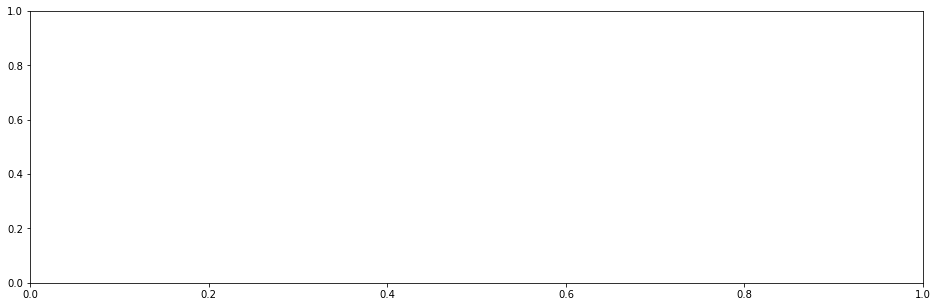

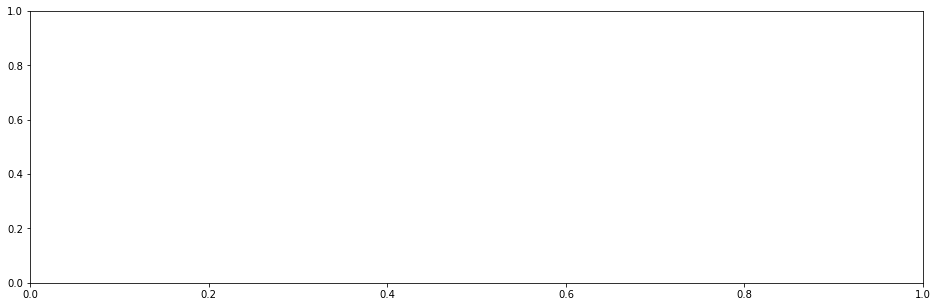

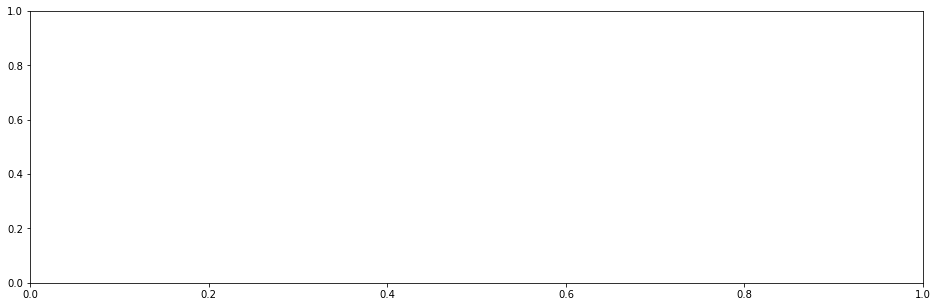

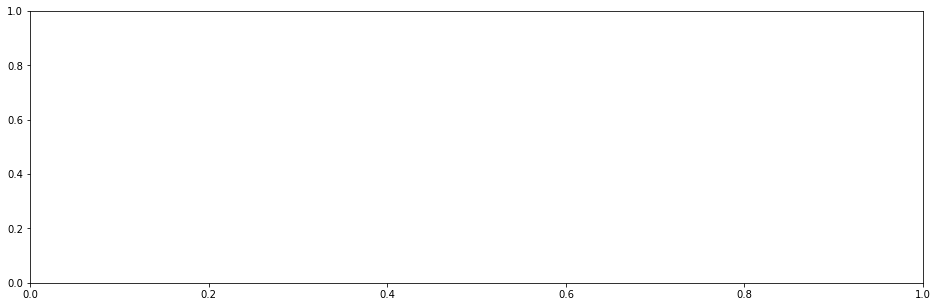

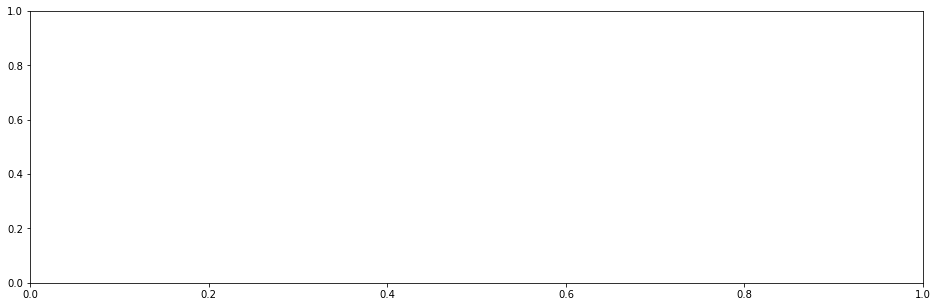

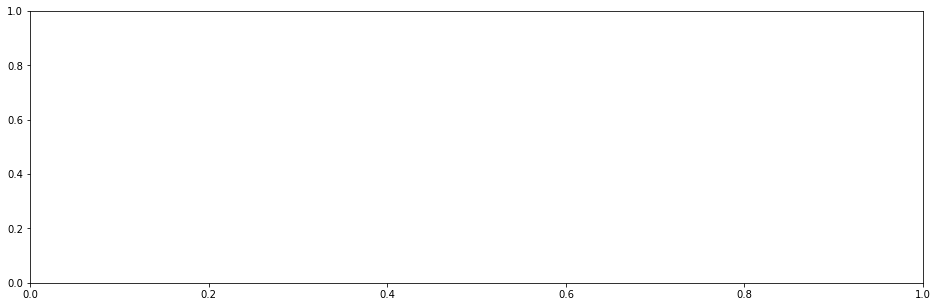

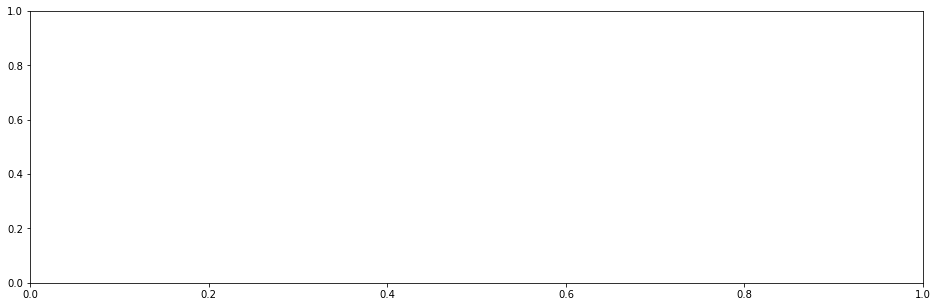

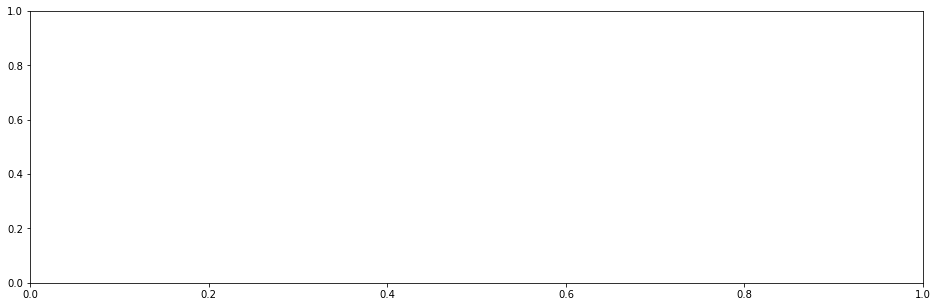

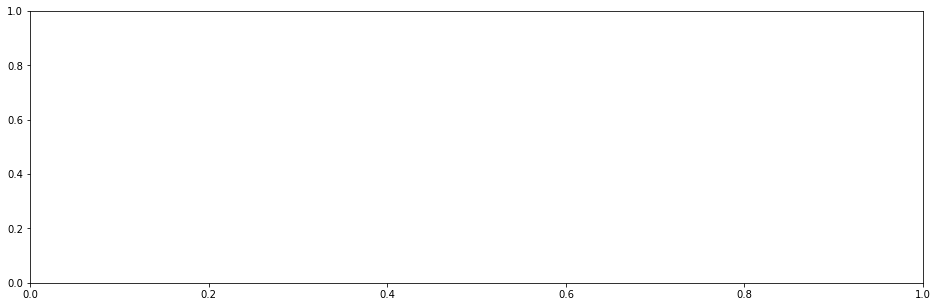

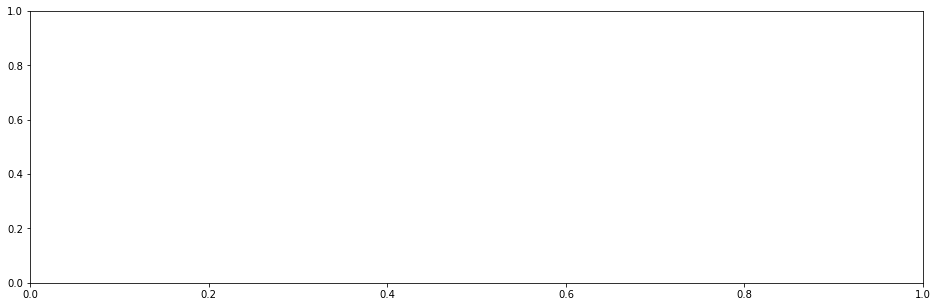

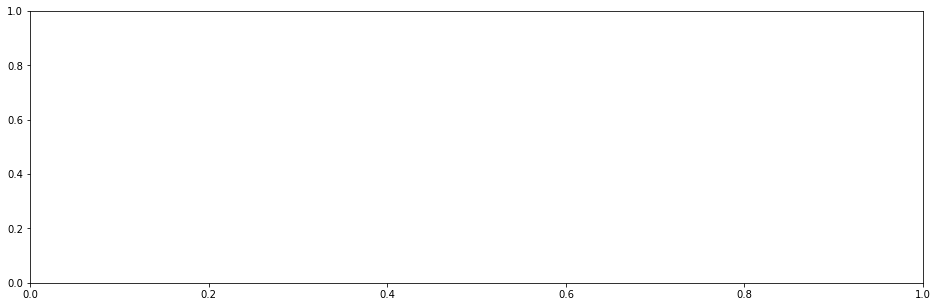

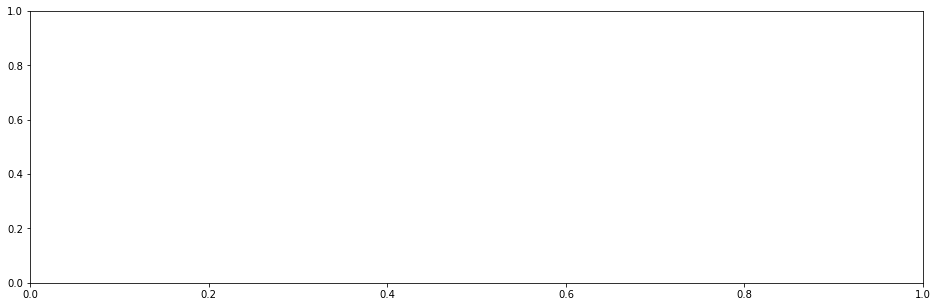

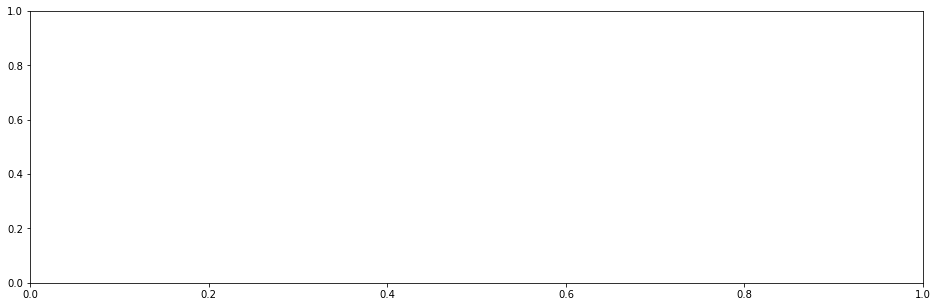

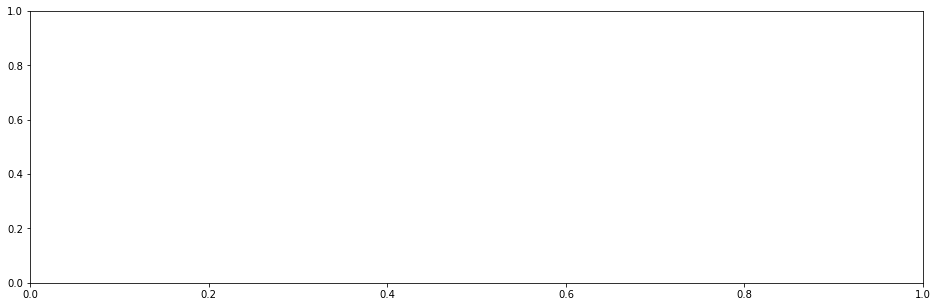

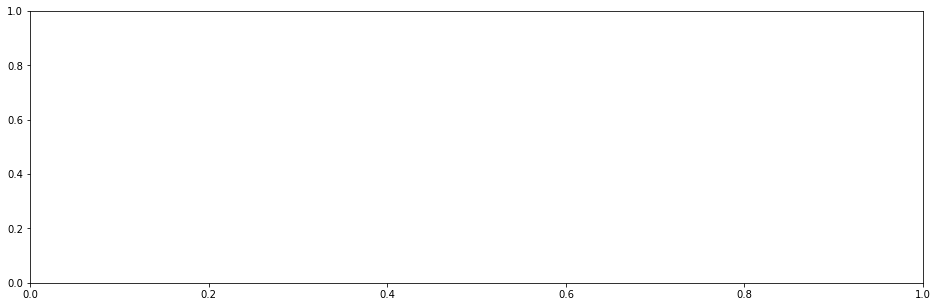

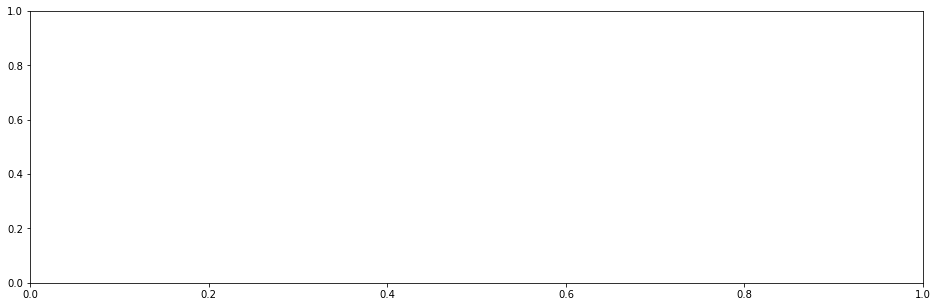

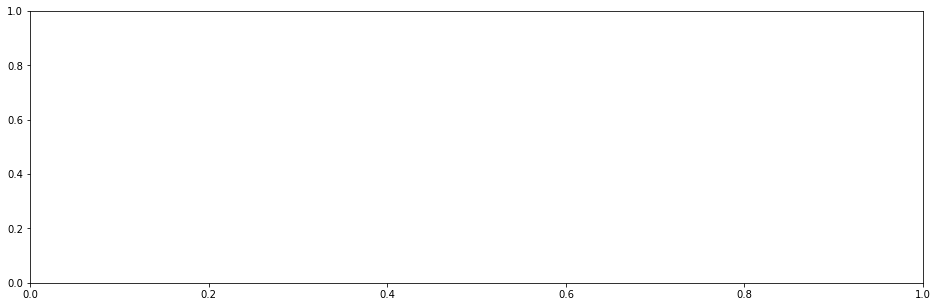

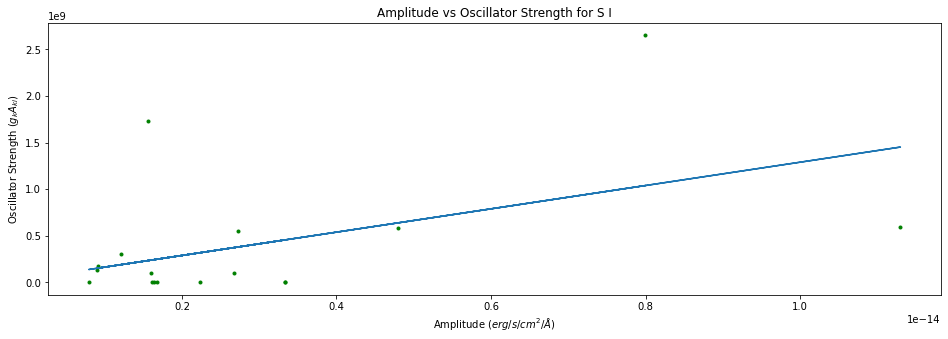

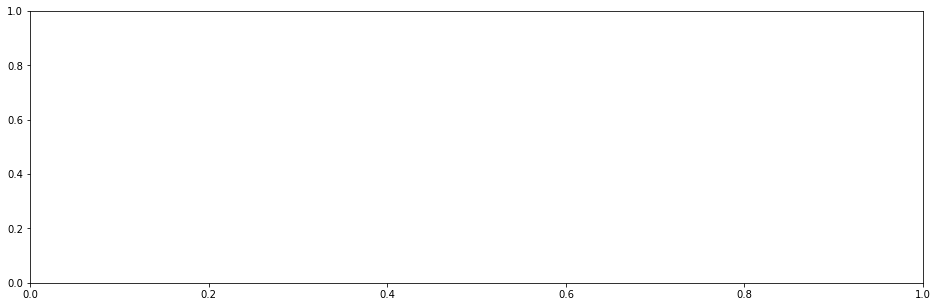

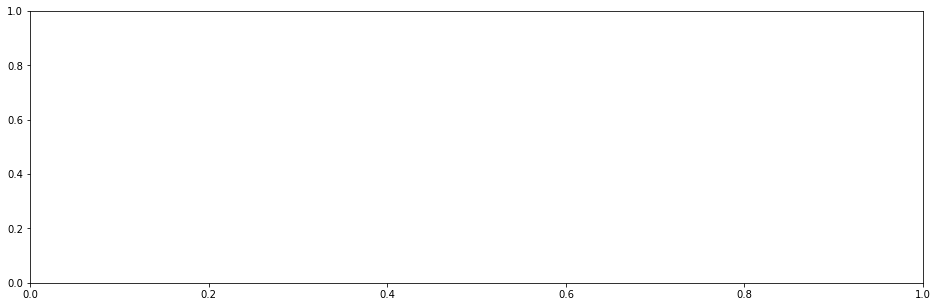

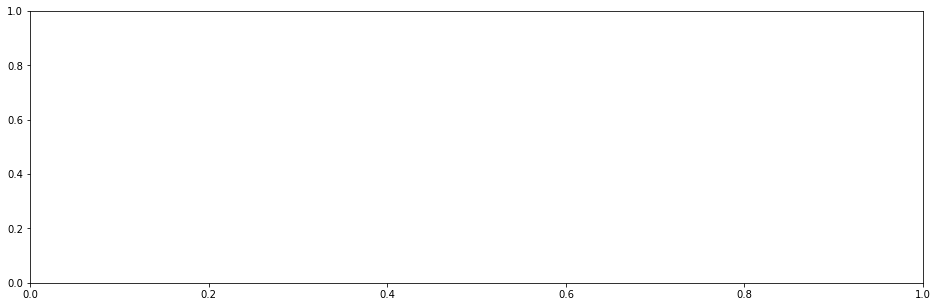

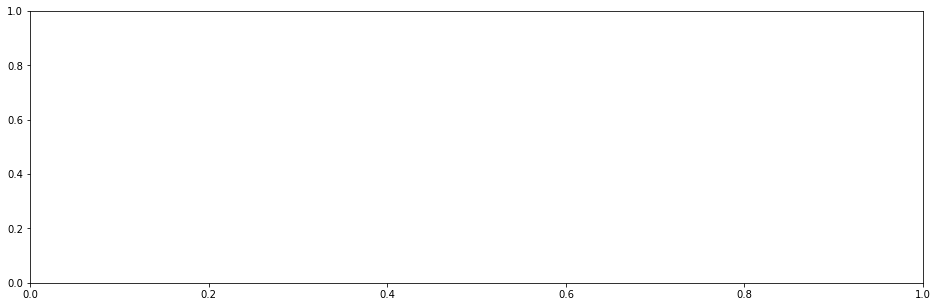

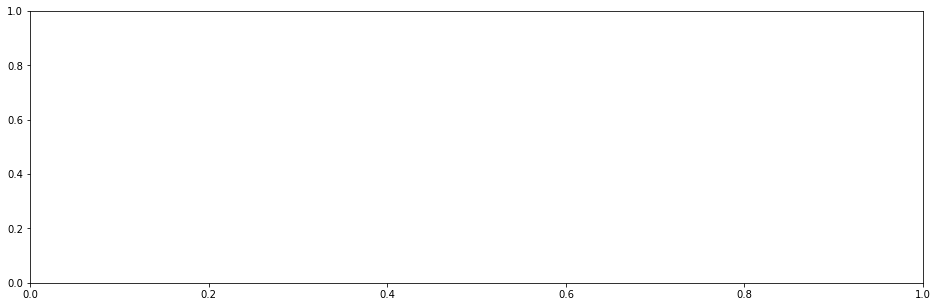

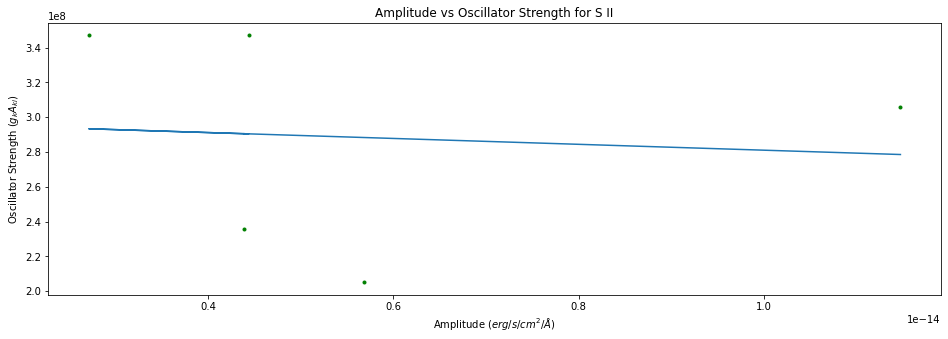

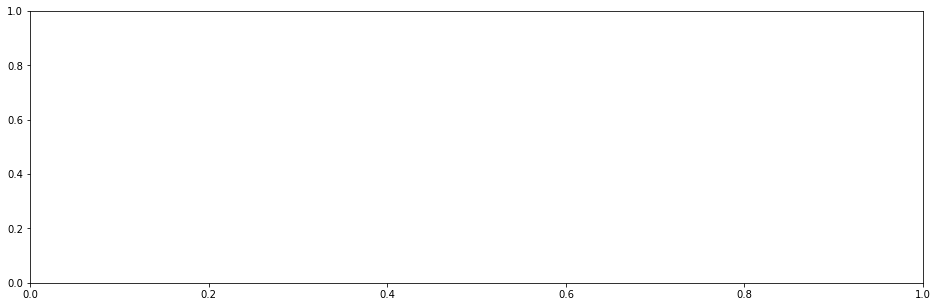

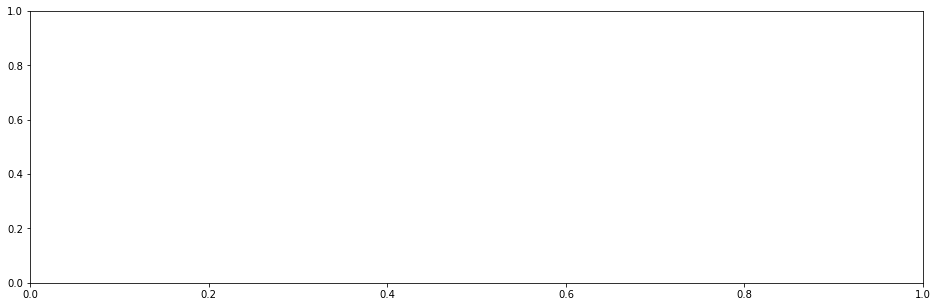

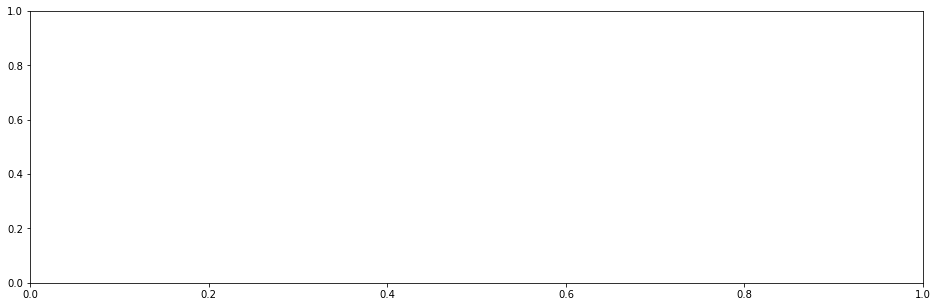

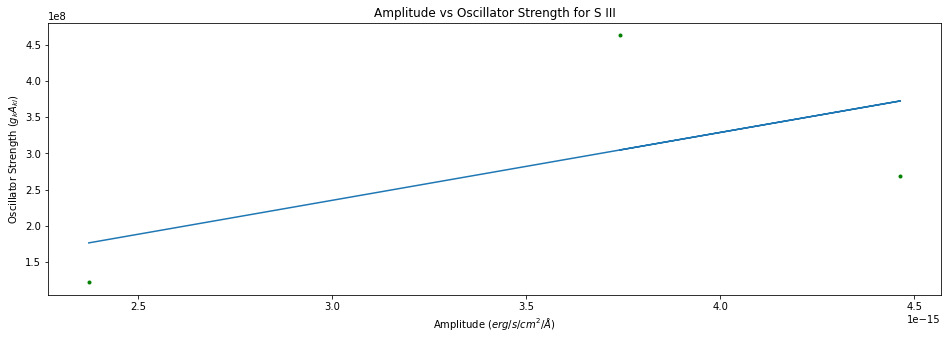

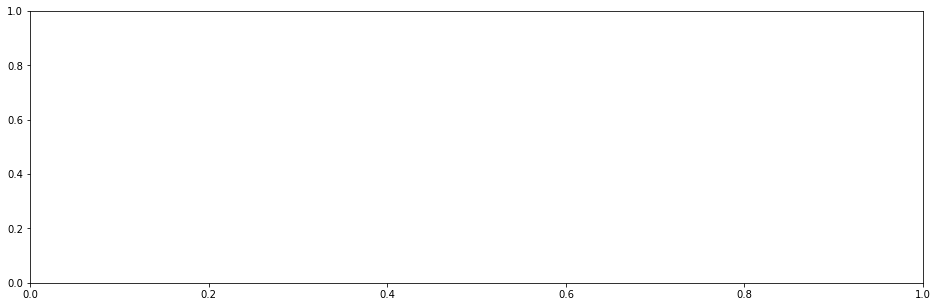

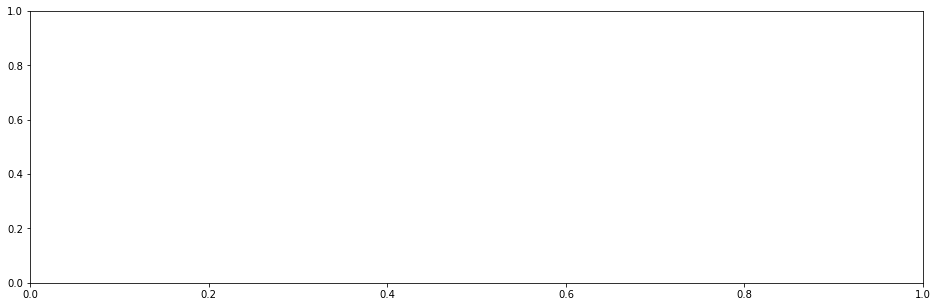

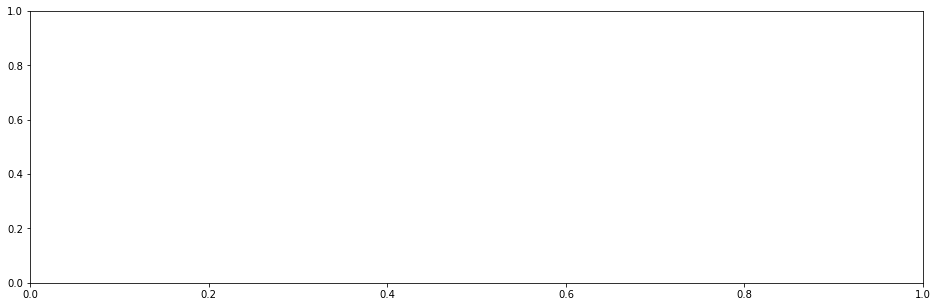

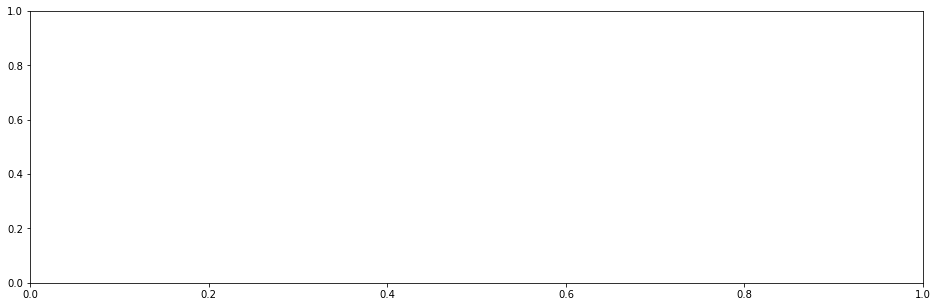

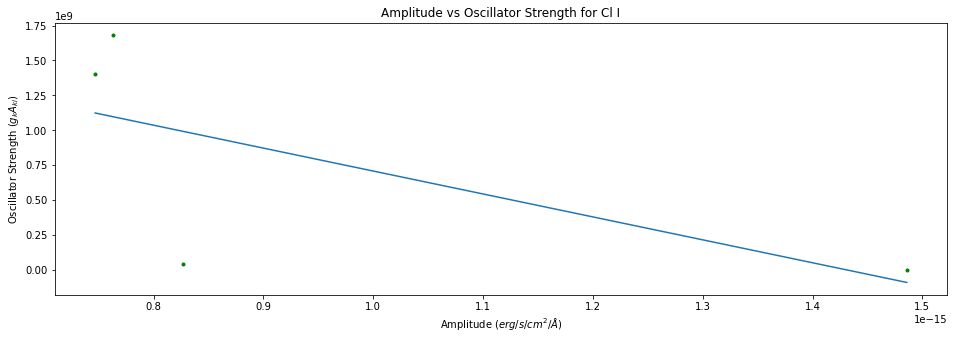

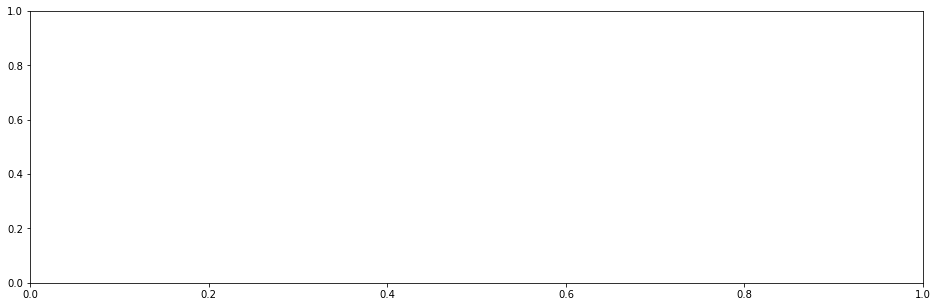

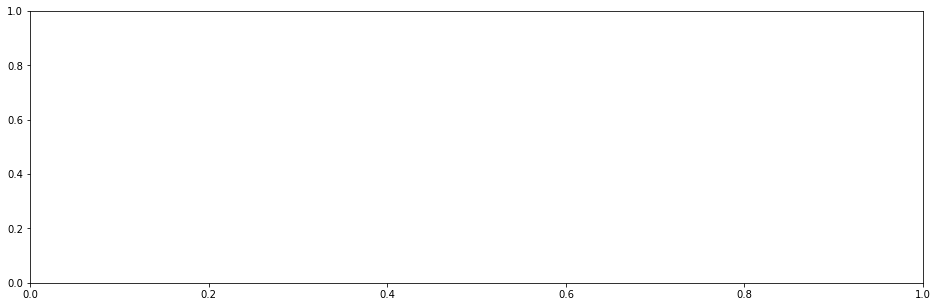

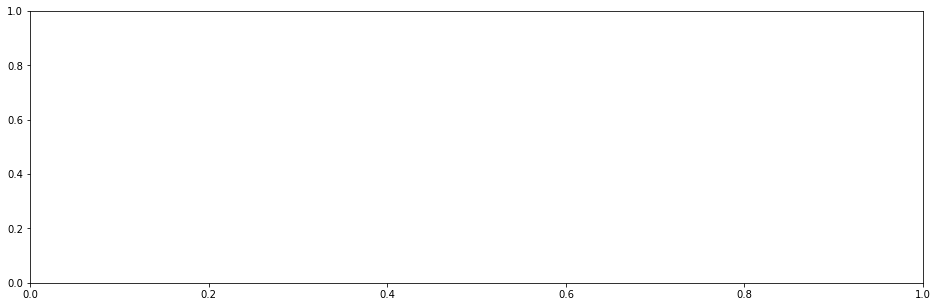

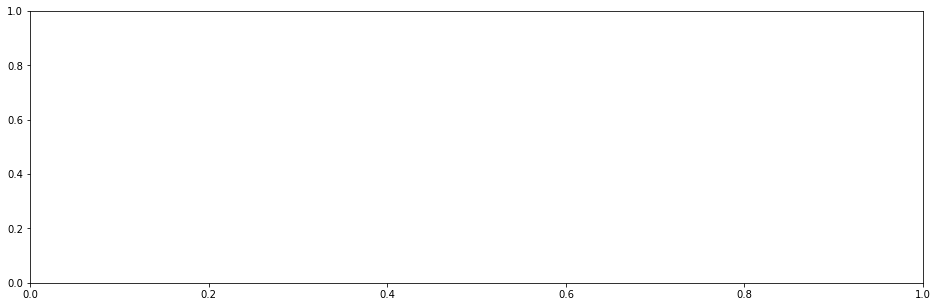

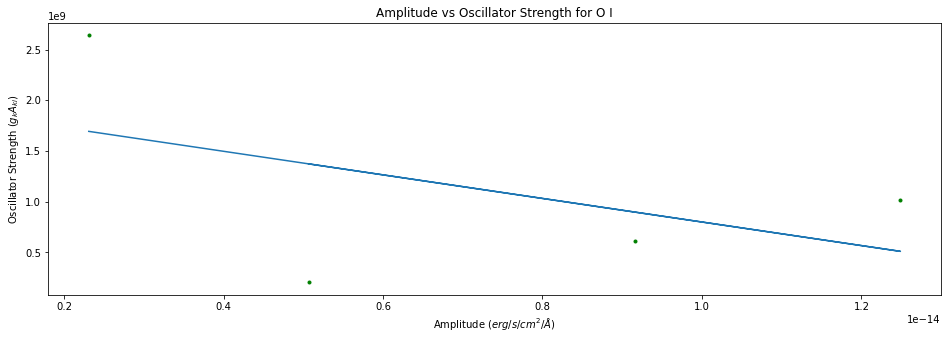

In [90]:
for i in range(0,len(lines)):
    line = lines[i]
    test,array_line = target_array(line)
    params = fit_whole_spectra(test)
    species_plot(line)